# Restauración Básica de Imágenes

## Introducción Teórica

Las imágenes que capturamos con cámaras no siempre son perfectas. A menudo sufren **degradaciones**, como ruido (granitos, interferencias) o desenfoque (pérdida de nitidez). La **restauración de imágenes** busca mejorar la calidad de una imagen degradada, intentando recuperar la imagen original lo mejor posible.

Hoy nos enfocaremos en un tipo específico de degradación: el **desenfoque por movimiento horizontal uniforme**. Imagina que tomas una foto y la cámara se mueve horizontalmente mientras el obturador está abierto. Esto causa que los objetos en la imagen aparezcan "barridos" o estirados horizontalmente.

**¿Cómo se simula esta degradación?**

Podemos modelar este desenfoque como si cada píxel original se "esparciera" horizontalmente, promediándose con sus vecinos en la dirección del movimiento. Esto se logra aplicando un filtro de promedio horizontal a la imagen original.

*   $\bf F$: Imagen Original
*   $\bf G$: Imagen Degradada (desenfocada)
*   $\bf \hat F$: Imagen Restaurada

**¿Cómo se restaura la imagen?**

Existen métodos matemáticos que, conociendo o estimando cómo fue la degradación (el "filtro de desenfoque"), intentan "revertir" el proceso. Estos métodos a menudo buscan encontrar la imagen original ($\bf \hat F$) que, al ser degradada, se parezca lo más posible a la imagen que observamos ($\bf G$). Uno de estos métodos se basa en minimizar una función de error, a veces con términos adicionales para que la imagen restaurada se vea natural (esto se llama regularización).

En este cuaderno, usaremos una función (`res_minio`) que implementa uno de estos algoritmos de restauración. No entraremos en los detalles matemáticos profundos de su derivación (que involucra álgebra lineal avanzada y multiplicadores de Lagrange), sino que nos enfocaremos en su aplicación y en entender conceptualmente qué hace.

In [1]:
# Instalación e Importación de Librerías
# OpenCV y Matplotlib suelen estar preinstalados en Colab, pero es buena práctica incluirlo.
# !pip install opencv-python matplotlib

import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, filter2D, IMREAD_GRAYSCALE, CV_64F
from google.colab.patches import cv2_imshow # Para mostrar imágenes con OpenCV en Colab

print("Librerías importadas.")

Librerías importadas.


In [2]:
## Descarga de Imágenes de Ejemplo

!wget -O santiago.png https://www.dropbox.com/s/w9tew0pn2259kgl/santiago.png
!wget -O puerta_bw.png https://www.dropbox.com/s/i62imnk7j0ot430/puerta_bw.png
!wget -O santiago512.png https://www.dropbox.com/s/z0bkrak7n5n19qg/santiago512.png

print("Imágenes descargadas.")

--2025-05-08 07:33:18--  https://www.dropbox.com/s/w9tew0pn2259kgl/santiago.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5zkmyirx6caw4d1xip6tn/santiago.png?rlkey=hi1qlcea3s9gyk0ynuc5g2jen [following]
--2025-05-08 07:33:18--  https://www.dropbox.com/scl/fi/5zkmyirx6caw4d1xip6tn/santiago.png?rlkey=hi1qlcea3s9gyk0ynuc5g2jen
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccce312bc5b27a184a784223183.dl.dropboxusercontent.com/cd/0/inline/CpT9QdzYmCH-LRmoKSoHF_zORaPA5UnAT7ayM5k7XBUpTYVxtH4j7YOi4XnPnsae-5MxjSbnvr1yUiGL8nT8U97MbHhXF5QRu0cm9Om21CLYQGCZkiekSwMkidzqwIZ7lWU/file# [following]
--2025-05-08 07:33:19--  https://uccce312bc5b27a184a784223183.dl.dropboxusercontent.com/cd/0/inline/CpT9QdzYmCH-LRmoKSoHF_

## 1. Simulación del Desenfoque por Movimiento Horizontal

Vamos a tomar una imagen original y aplicarle un filtro para simular el desenfoque.
El filtro `h` será un promedio de `n_desenfoque` píxeles en horizontal.

Imagen original 'santiago512.png' cargada. Dimensiones: (512, 512)
Imagen degradada generada. Dimensiones: (512, 313)


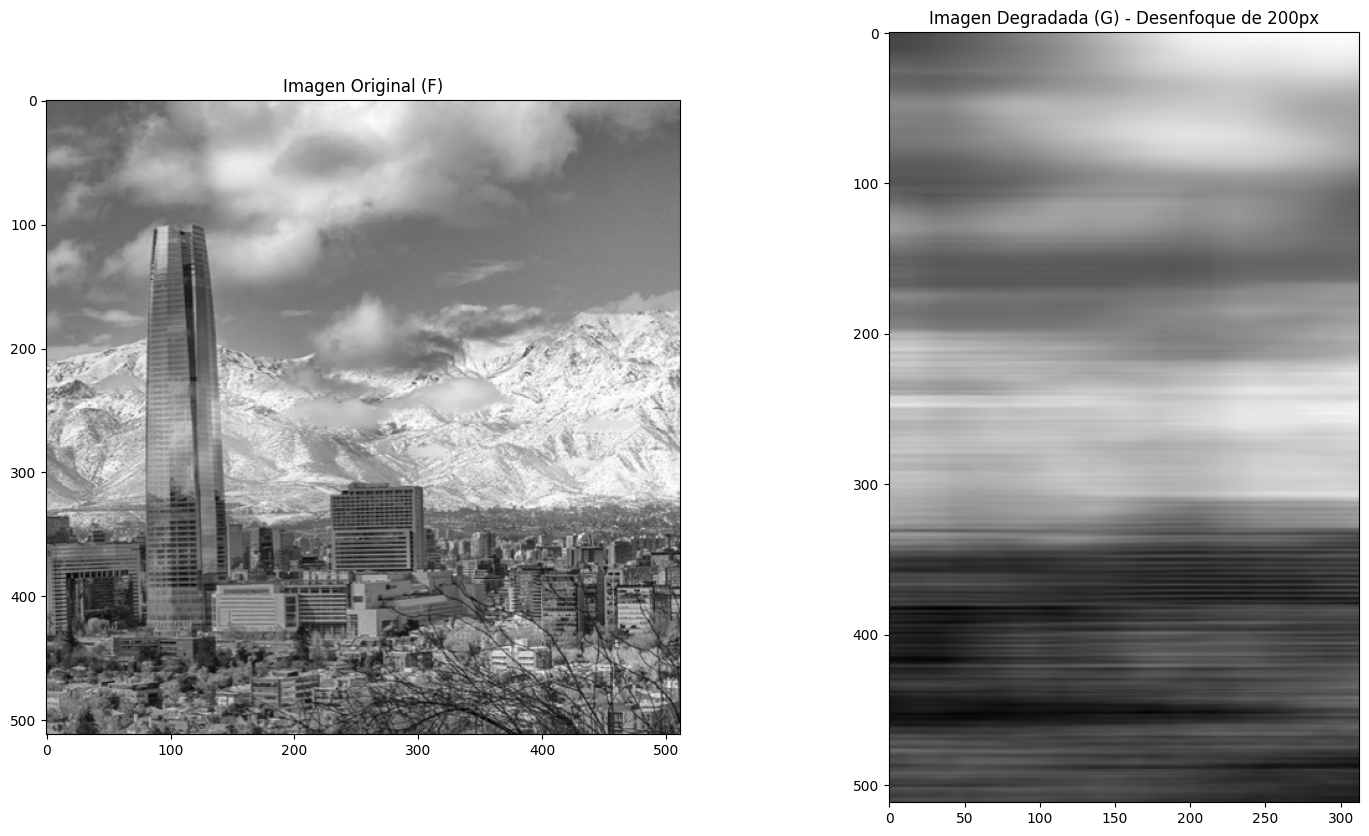

In [6]:
# Cargar imagen original y simular degradación
# Podes probar cambiando la imagen (ej: 'santiago.png', 'puerta_bw.png')

nombre_imagen_original = 'santiago512.png'
img_original_cv = imread(nombre_imagen_original, IMREAD_GRAYSCALE)

if img_original_cv is None:
    print(f"Error: No se pudo cargar la imagen {nombre_imagen_original}")
else:
    print(f"Imagen original '{nombre_imagen_original}' cargada. Dimensiones: {img_original_cv.shape}")

    # --- Parámetros del Desenfoque ---
    # Prueba cambiando este valor (ej: 50, 100, 150)
    n_desenfoque = 200
    # ----------------------------------

    # Creamos el filtro de desenfoque (PSF - Point Spread Function)
    # Es un filtro promedio de 1xn_desenfoque
    h_filtro = np.ones((1, n_desenfoque)) / n_desenfoque

    # Obtenemos las dimensiones para la imagen degradada
    # La imagen degradada será más angosta que la original debido al filtro
    N_ancho_original = img_original_cv.shape[1]
    M_ancho_degradado = N_ancho_original - n_desenfoque + 1

    # Aplicamos el filtro para degradar la imagen
    # Usamos filter2D de OpenCV. Convertimos la imagen a tipo 'double' (CV_64F) para la convolución.
    img_degradada_cv = filter2D(img_original_cv.astype('double'), CV_64F, h_filtro)

    # Recortamos la imagen degradada al ancho M_ancho_degradado
    # El filtro produce bordes, y la parte "válida" de la convolución es más pequeña.
    img_degradada_cv = img_degradada_cv[:, 0:M_ancho_degradado]

    print(f"Imagen degradada generada. Dimensiones: {img_degradada_cv.shape}")

    # Mostrar imágenes con Matplotlib
    plt.figure(figsize=(18, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original_cv, cmap='gray')
    plt.title('Imagen Original (F)')
    plt.axis('on') # Mostrar ejes para ver dimensiones

    plt.subplot(1, 2, 2)
    plt.imshow(img_degradada_cv, cmap='gray')
    plt.title(f'Imagen Degradada (G) - Desenfoque de {n_desenfoque}px')
    plt.axis('on')

    plt.show()

## 2. Algoritmo de Restauración (Función `res_minio`)

La siguiente función, `res_minio`, implementa un algoritmo de restauración.
Como mencionamos, se basa en principios matemáticos para estimar la imagen original ($\bf \hat F$) a partir de la imagen degradada ($\bf G$) y el conocimiento del filtro de desenfoque (`h_filtro`).

Utiliza un parámetro $\lambda$ (lambda_multiplicador) que ayuda a regularizar la solución, es decir, a que la imagen restaurada no tenga demasiado "ruido" o artefactos no deseados.
El método 'minio' implementa la solución a:
$
V({\bf f}) = \lambda\parallel{\bf H}{\bf f}-{\bf g}\parallel^2 +\parallel{\bf  P}{\bf  f}\parallel^2
$
donde $\bf P$ es un operador que busca la solución más parecida a la imagen original. En la práctica, se usan matrices para representar estas operaciones.
No te preocupes por los detalles internos de la función por ahora, ¡veamos cómo funciona!

In [7]:
# Definición de la función de restauración res_minio

def res_minio(_img_g, h, method='minio'):
    """
    Restaura una imagen degradada.

    Args:
        _img_g: imagen degradada (desenfocada) como array de numpy.
        h: PSF (filtro de desenfoque) como array de numpy.
        method: método de minimización ('minio' o 'eye'). Usaremos 'minio'.

    Returns:
        _img_f: la imagen restaurada como array de numpy.
    """
    _valid_methods = ['minio', 'eye']

    if not isinstance(_img_g, np.ndarray):
        raise Exception('Formato de entrada no válido para _img_g.')
    if not isinstance(h, np.ndarray):
        raise Exception('Formato no válido para h (PSF).')
    if method not in _valid_methods:
        raise ValueError(f'Método no válido. Usar uno de: {_valid_methods}')

    nh = h.shape[-1]  # Ancho del filtro h
    n_ancho_degradado = _img_g.shape[-1] # Ancho de la imagen degradada
    m_ancho_restaurado = n_ancho_degradado + nh - 1 # Ancho estimado de la imagen restaurada/original

    # Construcción de la matriz H (representa la operación de degradación)
    _mat_h = np.zeros((n_ancho_degradado, m_ancho_restaurado))
    for i in range(n_ancho_degradado):
        _mat_h[i, i:i + nh] = h.ravel() # Coloca el filtro h en cada fila desplazada

    lambda_multiplicador = 1e6  # Multiplicador de Lagrange (parámetro de regularización)

    if method == 'minio':
        # Matriz P para el criterio MINIO
        _mat_p = np.hstack([np.eye(n_ancho_degradado, dtype='float'), np.zeros((n_ancho_degradado, nh - 1))])

        # Aplicación de la fórmula de restauración (simplificada conceptualmente)
        # Resuelve: f_hat = ( (H_trans * H * lambda) + (P_trans * P) )^-1 * (H_trans * g * lambda + P_trans * g)
        # La fórmula original del script parece tener una ligera variación o simplificación para este caso específico.
        # La fórmula usada en el script original es:
        # f_hat = g @ (lambda * H + P) @ inv( (lambda * H).T @ H + P.T @ P ).T
        # Esto parece una forma de resolver la ecuación normal. Lo mantendremos como en el original.

        # El producto @ es producto de matrices. .T es transpuesta. np.linalg.inv es inversa.
        termino1 = lambda_multiplicador * _mat_h + _mat_p
        termino_mat_h_trans = _mat_h.T
        termino_mat_p_trans = _mat_p.T

        # Matriz a invertir: (lambda * H^T * H + P^T * P)
        matriz_a_invertir = (lambda_multiplicador * termino_mat_h_trans @ _mat_h) + (termino_mat_p_trans @ _mat_p)

        try:
            inversa_matriz = np.linalg.inv(matriz_a_invertir)
        except np.linalg.LinAlgError:
            print("Error: La matriz no es invertible. Usando pseudo-inversa (puede ser menos precisa).")
            inversa_matriz = np.linalg.pinv(matriz_a_invertir)


        _img_f = _img_g @ termino1 @ inversa_matriz.T


    elif method == 'eye': # Regularización de Tikhonov simple (W = I)
        # f_hat = g @ H @ inv( (lambda * H).T @ H + I ).T
        # Esta es una forma más estándar de regularización de Tikhonov.
        matriz_a_invertir = (lambda_multiplicador * _mat_h.T @ _mat_h) + np.eye(m_ancho_restaurado, dtype='float')

        try:
            inversa_matriz = np.linalg.inv(matriz_a_invertir)
        except np.linalg.LinAlgError:
            print("Error: La matriz no es invertible. Usando pseudo-inversa (puede ser menos precisa).")
            inversa_matriz = np.linalg.pinv(matriz_a_invertir)

        _img_f = _img_g @ _mat_h @ inversa_matriz.T

    # Ajustar los valores de los píxeles al rango [0, 255]
    _img_f[_img_f < 0] = 0
    _img_f[_img_f > 255] = 255

    return _img_f

print("Función res_minio definida.")

Función res_minio definida.


## 3. Aplicación de la Restauración

Ahora, aplicaremos la función `res_minio` a nuestra imagen degradada `img_degradada_cv`.

Restaurando la imagen... (esto puede tardar un momento)
Imagen restaurada generada. Dimensiones: (512, 512)


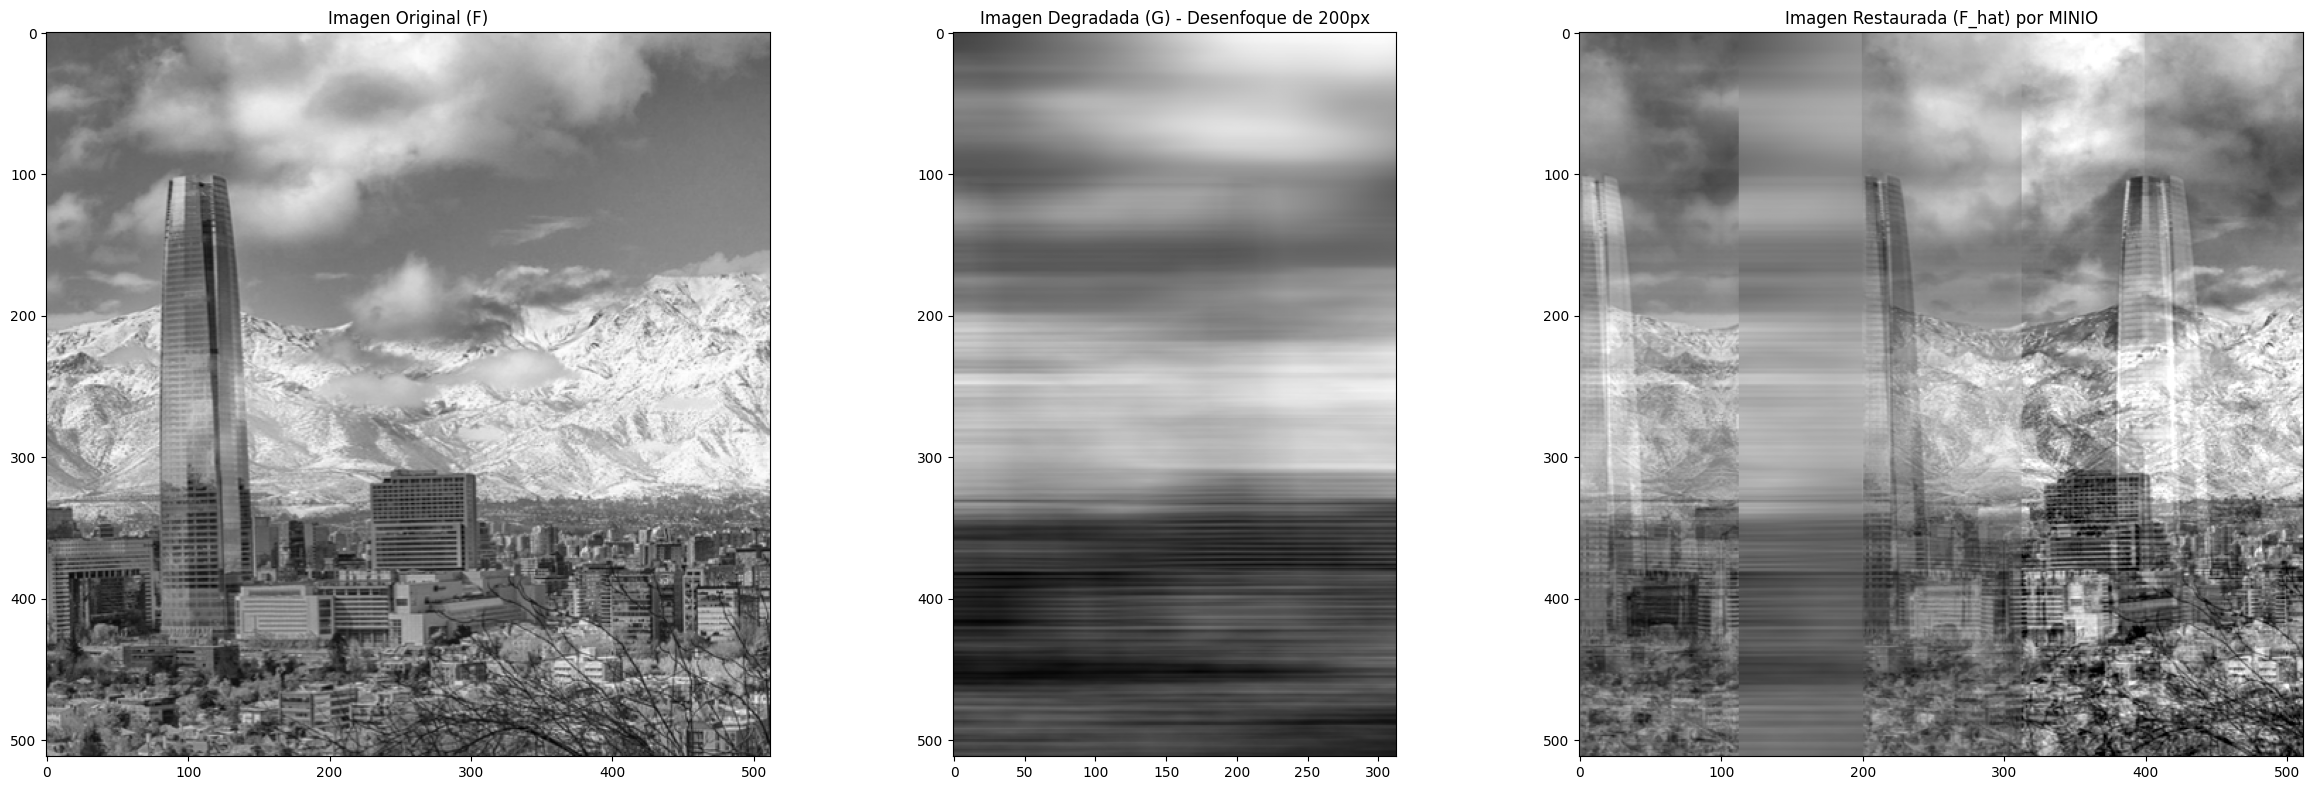

In [8]:
# Celda 5: Restaurar la imagen y mostrar resultados

if 'img_degradada_cv' not in globals() or img_degradada_cv is None:
    print("Error: Primero debes ejecutar la celda 3 para generar la imagen degradada.")
else:
    print("Restaurando la imagen... (esto puede tardar un momento)")
    # Aplicamos la restauración
    img_restaurada_fs = res_minio(img_degradada_cv, h_filtro, method='minio')
    print(f"Imagen restaurada generada. Dimensiones: {img_restaurada_fs.shape}")

    # Mostrar las tres imágenes: Original, Degradada y Restaurada
    plt.figure(figsize=(24, 8)) # Ajustar tamaño para tres imágenes

    plt.subplot(1, 3, 1)
    plt.imshow(img_original_cv, cmap='gray')
    plt.title('Imagen Original (F)')
    plt.axis('on')

    plt.subplot(1, 3, 2)
    plt.imshow(img_degradada_cv, cmap='gray')
    plt.title(f'Imagen Degradada (G) - Desenfoque de {n_desenfoque}px')
    plt.axis('on')

    plt.subplot(1, 3, 3)
    plt.imshow(img_restaurada_fs, cmap='gray')
    plt.title('Imagen Restaurada (F_hat) por MINIO')
    plt.axis('on')

    plt.tight_layout() # Ajusta el espaciado entre subplots
    plt.show()

## Experimentación

*   **Cambia `nombre_imagen_original` en la Celda 3** a 'santiago.png' o 'santiago512.png' y vuelve a ejecutar las celdas 3 y 5. ¿Cómo se ve la restauración?
*   **Cambia `n_desenfoque` en la Celda 3** a valores diferentes (ej. 30, 80, 200). Observa cómo un desenfoque mayor es más difícil de restaurar.
*   La calidad de la restauración depende de qué tan bien conocemos el proceso de degradación (el filtro `h_filtro`) y de la efectividad del algoritmo de restauración.